# Notebook de debug

notebook para ir probando algunas cosas en vivo sin tener que recurrir al navegador

# Setup del notebook

Cosas previas a tener seteadas para que el codigo funcione

In [3]:
import sqlite3
import pandas as pd
import os

In [4]:
THIS_FOLDER = os.path.dirname(os.path.abspath("__file__"))
THIS_FOLDER

'/home/tomas/workspace/uba/sr/sr-tpfinal-gh-web'

In [5]:
interacciones = 'interactions'
items = 'repositories'
users = 'users'

# Datasets

carga de los datasets desde la base sqlite

In [6]:
con = sqlite3.connect(os.path.join(THIS_FOLDER, "data/data.db"))
df_int = pd.read_sql_query(f"SELECT * FROM {interacciones}", con)
original_df_items = pd.read_sql_query(f"SELECT * FROM {items}", con)
df_users = pd.read_sql_query(f"SELECT * FROM {users}", con)
con.close()

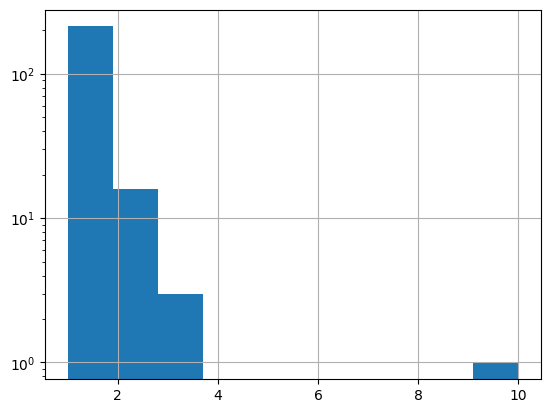

In [7]:
#original_df_items.archived.value_counts()
original_df_items.forks.value_counts().hist(log=True);

In [8]:
df_items = original_df_items.drop(["es_fork", "about", "archived", "topics", "language"], axis=1)

In [9]:
df_int

,index,repository,user,date
0,0.0,tensorflow/tensorflow,mrry,2015-11-09 13:17:30
1,1.0,tensorflow/tensorflow,danbri,2015-11-09 13:18:49
2,2.0,tensorflow/tensorflow,rockt,2015-11-09 13:40:12
3,3.0,tensorflow/tensorflow,petro-rudenko,2015-11-09 13:40:58
4,4.0,huggingface/transformers,kashif,2018-11-05 15:19:44
...,...,...,...,...
22021,NaN,SerpentAI/SerpentAI,fly51fly,2023-11-27 19:39:38
22022,NaN,bbfamily/abu,fly51fly,2023-12-04 20:45:49
22023,NaN,streamlit/streamlit,fly51fly,2023-12-07 19:40:48
22024,NaN,jackzhenguo/python-small-examples,fly51fly,2023-12-07 19:40:46


# Trabajando con los lenguajes

Se trabaja con los lenguajes de programación

In [119]:
# dummy de lenguajes y topics
df_languaje_dummies = original_df_items.language.str.get_dummies(sep=";")
df_topics_dummies = original_df_items.topics.str.get_dummies(sep=";")
df_perfil_items = pd.concat([df_items, df_languaje_dummies, df_topics_dummies], axis=1)

# este perfil se puede precalcular offline y modificarlo ante cada cambio
df_perfil_items.shape

(263, 1182)

In [120]:
# usuario de quien construiremos el perfil
#username = "fly51fly" # user con 133 interacciones
username = "oudommeas" # user con 20 interacciones
#username = "zmughal" # user con 10 interacciones
#df_int["date"] = pd.to_datetime(df_int["date"], format="%Y-%m-%d %H:%M:%S")
repos_user = df_int.loc[
    (df_int["user"] == username),
    "repository"].to_list()

# me quedo con el perfil del usuario de los repos que le gustaron
perfil_user = df_perfil_items[df_perfil_items["id"].isin(repos_user)].drop(columns=["id", "index", "stars", "watchers", "forks", "issues", "subscribers"]).sum(axis=0).sort_values(ascending=False)
perfil_user = perfil_user / perfil_user.sum() # normalizo

# este perfil se puede precalcular offline y modificarlo ante cada cambio
perfil_user

Shell                  0.048611
HTML                   0.034722
Python                 0.034722
C++                    0.034722
JavaScript             0.034722
                         ...   
examples               0.000000
exif                   0.000000
experiment-track       0.000000
experiment-tracking    0.000000
zvt                    0.000000
Length: 1175, dtype: float64

In [121]:
df_perfil_user = df_perfil_items.drop(columns=["index", "stars", "watchers", "forks", "issues", "subscribers"]).set_index("id").copy()

# por ahora dimension son lenguajes, pero podria haber topics
for dimension in df_perfil_user.columns:
    df_perfil_user[dimension] = df_perfil_user[dimension] * perfil_user[dimension]

#recomendacion = df_perfil_user.sum(axis=1).sort_values(ascending=False)[:10].index

rank = df_perfil_user.sum(axis=1).sort_values(ascending=False)[:10]
df_recomendacion_scores = pd.DataFrame({'repository': rank.index, 'score': rank.values})
df_recomendacion_scores

df_recomendacion_fechas = (df_int[df_int["repository"].isin(list(df_recomendacion_scores.repository))].sort_values('date').groupby('repository').tail(1))[["repository", "date"]]
df_recomendacion_fechas

df_recomendacion = pd.merge(df_recomendacion_fechas, df_recomendacion_scores, on="repository")#.sort_values(['score', 'date'], ascending=[False, False])
#df_recomendacion["date"] = pd.to_datetime(df_recomendacion["date"], format="%Y-%m-%d %H:%M:%S")
df_recomendacion["date"] = pd.to_datetime(df_recomendacion["date"])
df_recomendacion = df_recomendacion.sort_values(['score', 'date'], ascending=[False, False])
list(df_recomendacion.reset_index(drop=True).repository)

['ray-project/ray',
 'TarrySingh/Artificial-Intelligence-Deep-Learning-Machine-Learning-Tutorials',
 'catboost/catboost',
 'pytorch/pytorch',
 'microsoft/computervision-recipes',
 'tensorflow/tensorflow',
 'h2oai/h2o-3',
 'explosion/spaCy',
 'apple/turicreate',
 'spmallick/learnopencv']

In [122]:
recomendaciones = [r for r in df_recomendacion.items()]
recomendaciones
df_recomendacion.to_dict()

{'repository': {4: 'ray-project/ray',
  6: 'TarrySingh/Artificial-Intelligence-Deep-Learning-Machine-Learning-Tutorials',
  5: 'catboost/catboost',
  9: 'pytorch/pytorch',
  8: 'microsoft/computervision-recipes',
  2: 'tensorflow/tensorflow',
  1: 'h2oai/h2o-3',
  0: 'explosion/spaCy',
  7: 'apple/turicreate',
  3: 'spmallick/learnopencv'},
 'date': {4: Timestamp('2017-04-01 04:49:49'),
  6: Timestamp('2017-08-19 17:41:46'),
  5: Timestamp('2017-07-18 10:08:39'),
  9: Timestamp('2023-11-27 19:38:55'),
  8: Timestamp('2019-10-08 11:03:07'),
  2: Timestamp('2015-11-09 14:39:29'),
  1: Timestamp('2015-02-16 21:20:16'),
  0: Timestamp('2015-01-25 18:38:41'),
  7: Timestamp('2017-12-08 22:46:39'),
  3: Timestamp('2016-03-19 14:05:53')},
 'score': {4: 0.5555555555555552,
  6: 0.43055555555555536,
  5: 0.41666666666666663,
  9: 0.4027777777777778,
  8: 0.375,
  2: 0.3680555555555555,
  1: 0.36111111111111105,
  0: 0.36111111111111105,
  7: 0.3541666666666667,
  3: 0.35416666666666663}}

# Codigo de prueba

In [67]:
#perfil_user = df_perfil_items[df_perfil_items["id"].isin(repos_user)].drop(columns=["id", "index"]).sum(axis=0).sort_values(ascending=False)
#perfil_user = df_perfil_items[df_perfil_items["id"].isin(repos_user)].drop(columns=["id", "index"]).sum(axis=0)#.reset_index()

#df_int.groupby('date')#['repository'].idxmax()
#df_int[(df_int["repository"].isin(rank.index)) & (df_int["date"] == df_int["date"].max())]
#df_int.drop(columns=['user'])[df_int.groupby('repository').date.transform('max') == df_int.date]
#(df_int[df_int["repository"].isin(recomendacion)].sort_values('date').groupby('repository').tail(1))[["repository", "date"]]

#df_int[df_int["repository"] == 'explosion/spaCy'].sort_values('date')

,repository,date
5987,explosion/spaCy,2015-01-25 18:38:41
5273,tensorflow/tensorflow,2015-11-09 14:39:29
6599,spmallick/learnopencv,2016-03-19 14:05:53
5885,ray-project/ray,2017-04-01 04:49:49
9302,catboost/catboost,2017-07-18 10:08:39
12872,TarrySingh/Artificial-Intelligence-Deep-Learni...,2017-08-19 17:41:46
7721,apple/turicreate,2017-12-08 22:46:39
8231,microsoft/computervision-recipes,2019-10-08 11:03:07
21191,kumikohime/gdrtmidi,2023-04-04 19:42:33
22002,pytorch/pytorch,2023-11-27 19:38:55


,index,repository,user,date
786,786.0,explosion/spaCy,ddaniels,2014-07-28 14:16:45
787,787.0,explosion/spaCy,Smerity,2014-07-30 22:45:10
788,788.0,explosion/spaCy,geovedi,2014-11-22 09:52:58
789,789.0,explosion/spaCy,widnyana,2014-11-23 17:56:35
790,790.0,explosion/spaCy,extempore,2014-12-19 15:22:37
...,...,...,...,...
5983,5983.0,explosion/spaCy,jkrukowski,2015-01-25 18:27:22
5984,5984.0,explosion/spaCy,programLyrique,2015-01-25 18:31:23
5985,5985.0,explosion/spaCy,parindam,2015-01-25 18:34:20
5986,5986.0,explosion/spaCy,bllchmbrs,2015-01-25 18:38:06
